# Statistical Causal Inference
**NCG613: Data Analytics Project - Practical 8**

This practical builds on the analysis we have done to this point by introducing fundamental statistical methods for assessing causal relationships using counterfactual frameworks. We will start with the basic assessment of average treatment effects in Rubin's potential outcomes framework, then move to a simple difference-in-differences analysis, before considering more complex (spatial) regression models with additional controls.

The research question that we are assessing in this practical is the causal effect of the construction of the Elizabeth Line on house prices. The [Elizabeth Line](https://en.wikipedia.org/wiki/Elizabeth_line) is the newest London Underground line, completed in 2022. To assess its impact on house prices, we will employ a very simplistic two time-period design: we'll consider houses sold in 2019 as "pre-intervention" and houses sold in 2024 as "post-intervention". If we were studying this question more rigorously we would need to question the assumption of *when* exactly we should consider time cutoffs for the rail line "treatment" - and if one year of observed sales provides a representative pattern on either side of the treatment - but this assumption will work for this simple example. In terms of the houses that we consider to be "treated", we will use those sold within 800m of one of the Elizabeth Line stations. Again, while this cutoff is somewhat arbitrary, 800m is a generally-accepted walkable distance to public transport in dense urban areas; under this assumption, properties within walking distance to the new stations should see a price premium. On the other hand, the "control" observations will be those located from 800m - 1600m from Elizabeth Line stations. While we still have to control for confounding features, the basic idea here is that properties *near* stations but *slightly further* away will be similar in terms of fundamental neighbourhood characteristics to the "treated" houses, with the key difference being proximity to the new Underground line.

The next question, of course, is which confounding features we need to adjust for in our analysis to control for bias. To systematically determine confounders (and to ensure that we are not accidentally stepping into additional forms of bias, such as collider bias, by including *too many* covariates), we can use a Directed Acyclic Graph (DAG) to diagram the hypothesied relationships of interest in this study.

As you can see from the DAG below, there are a number of pre-intervention sources of confounding that need to be adjusted for when estimating the total effect of Elizabeth Line construction (2022) on post-intervention house price, including distance to city centre, distance to existing transit ttations, the pre-intervention house price (2019), neighbourhood professional employment, and neighbourhood social deprivation. All of the confounders should be measured at the pre-intervention time period to avoid collider bias.

We can see from the structure of the DAG that pre-intervention house price is an important confounder to control for in this case, as pre-intervention house prices might plausibly impact the planning of the new Underground line (whether as a push or pull factor). This variable is a bit different form the other confounders, though, as it is directly a measure of the outcome (but at an earlier time period). We will see later on in the practical how we can more explicitly build the pre-intervention outcome into our analysis. We will also discuss the possible role of spatial effects in this framework.

*Note: Setup and installation instructions are in the repository README.*

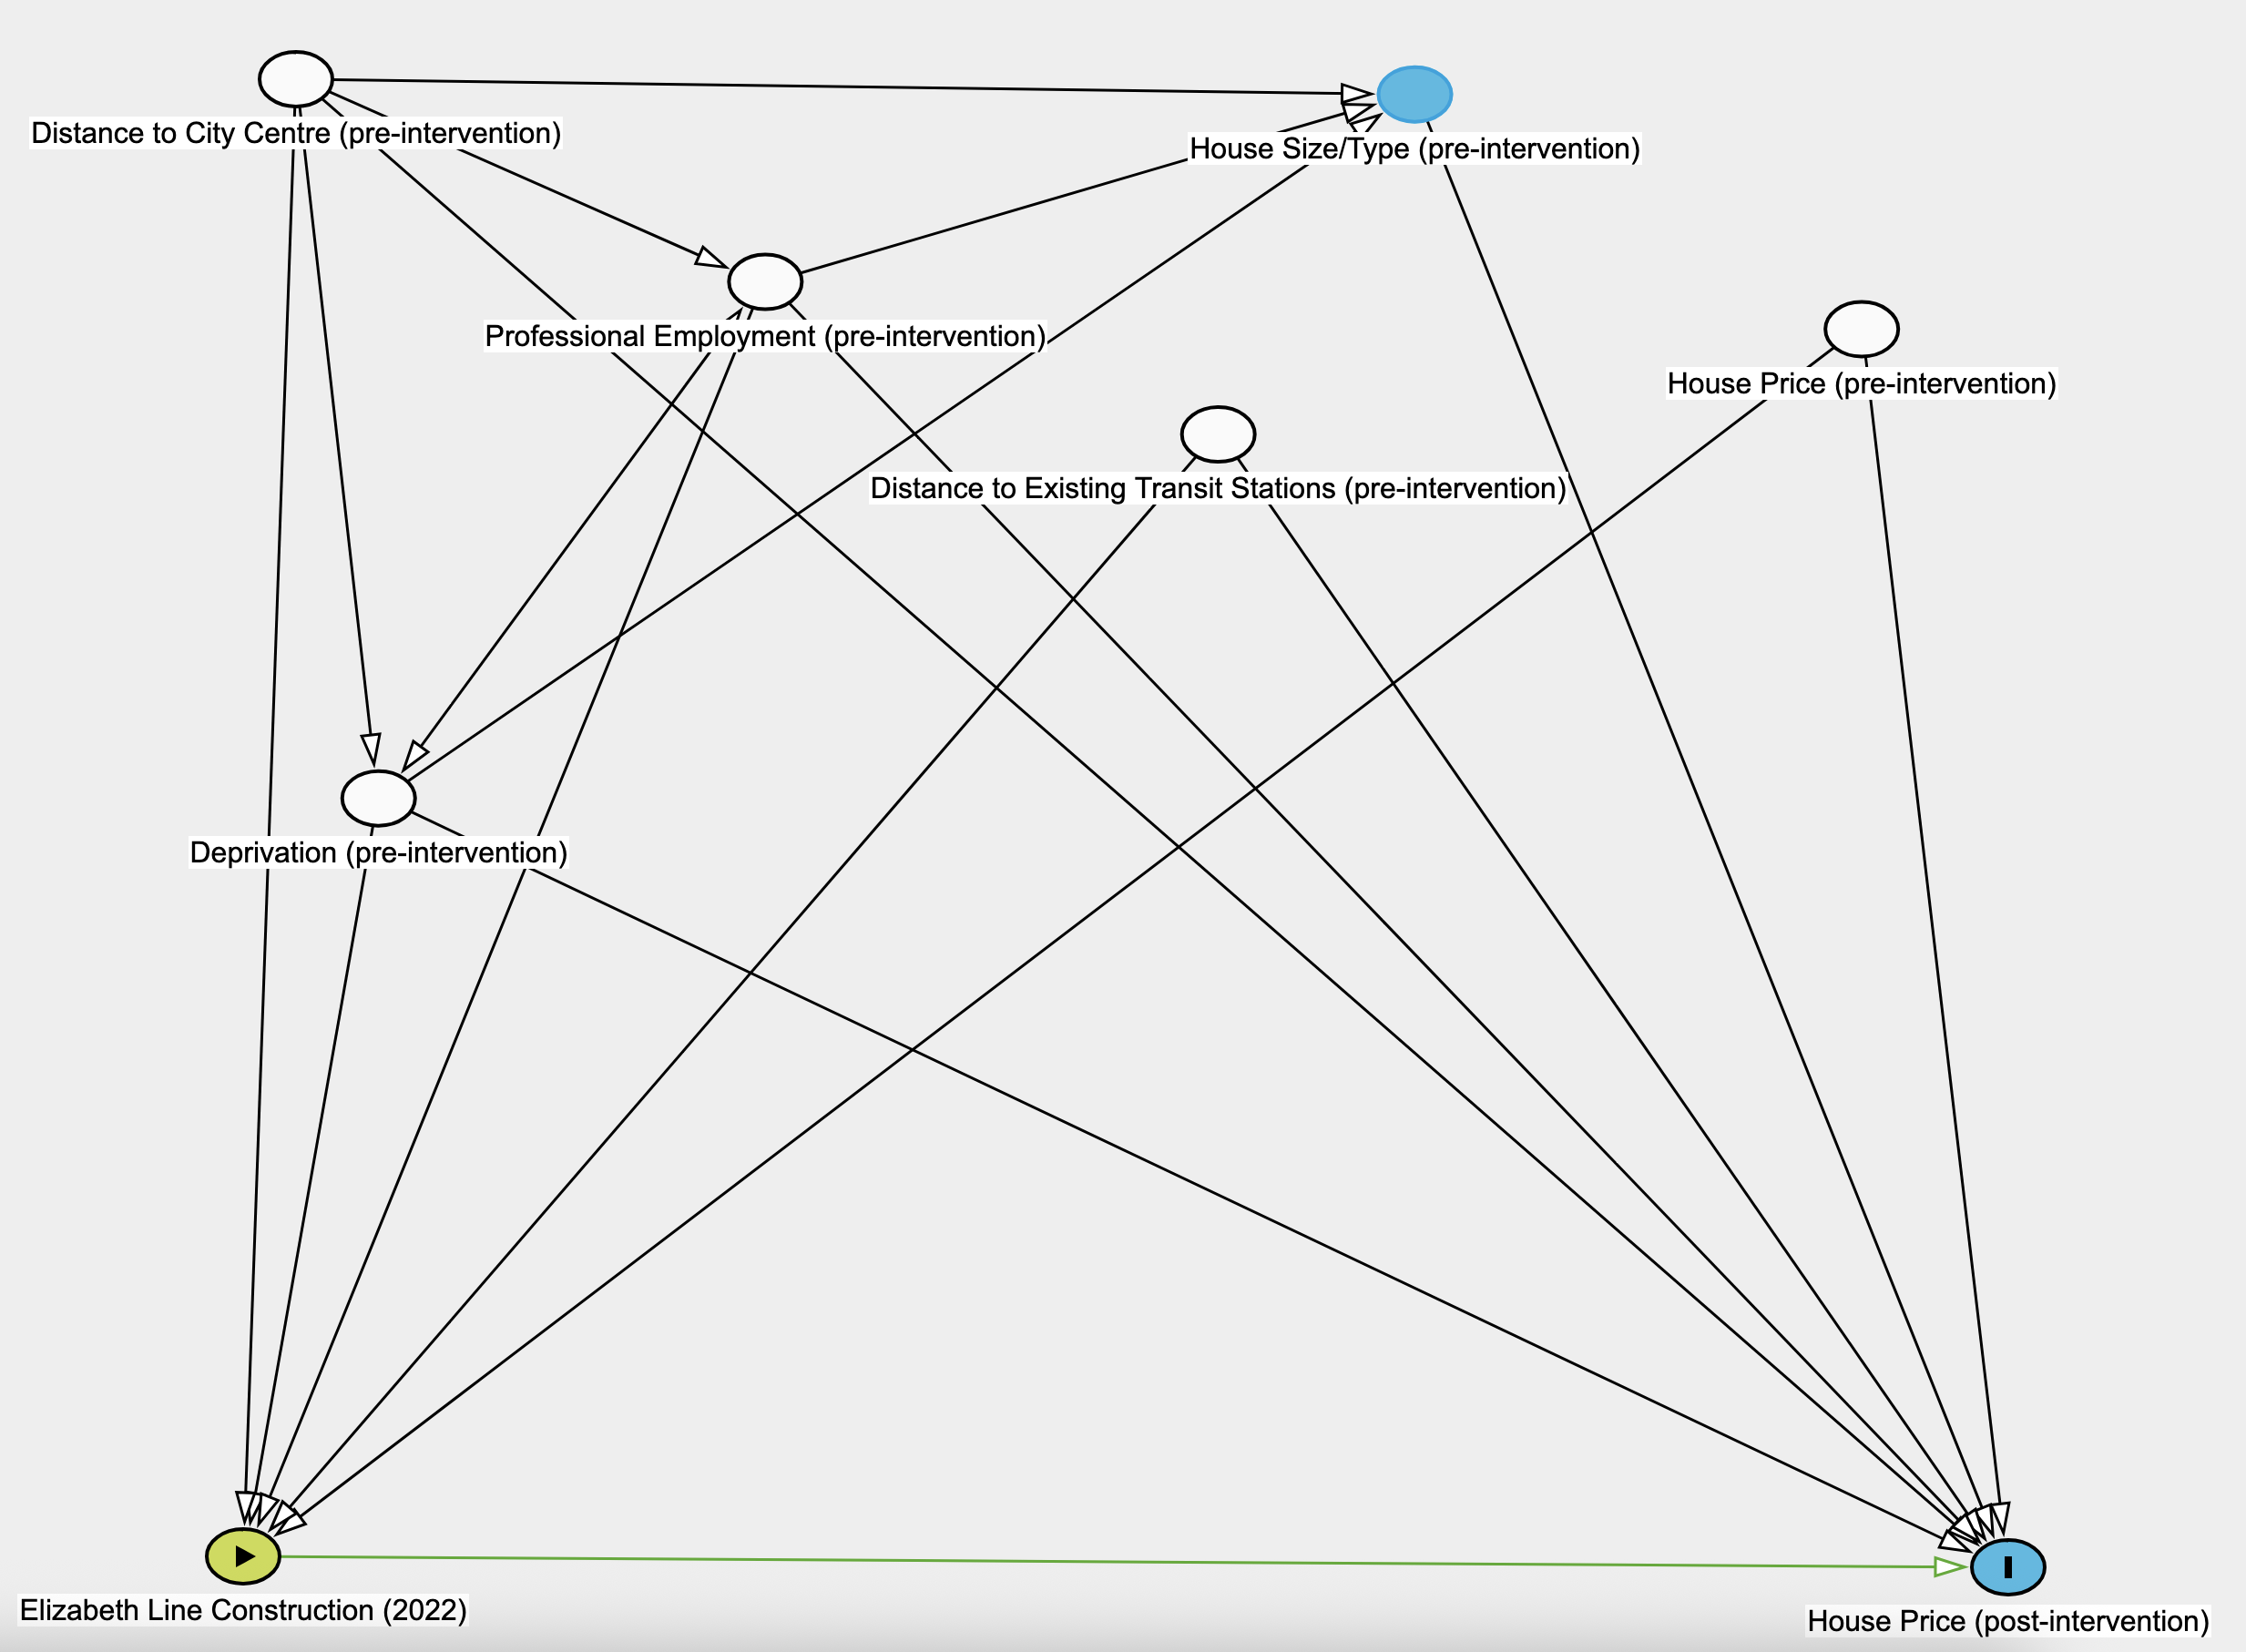

In [ ]:
# Import required packages
import matplotlib as mpl
from matplotlib import colors

%matplotlib inline
mpl.rcParams['figure.figsize'] = (15, 10) #this increases the inline figure size to 15 tall x 10 wide

import seaborn
import pandas as pd
import geopandas as gpd
import pysal
import numpy as np
import mapclassify
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # Change settings so that warnings are not displayed

import contextily as cx
from shapely.geometry import Polygon
import plotly.express as px
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from splot.esda import plot_local_autocorrelation
from splot.esda import lisa_cluster
from esda.moran import Moran_Local

# Loading a few new packages
from scipy import stats
from pysal.model import spreg
import statsmodels.formula.api as sm

import libpysal.weights as weights
import numpy as np
from scipy.stats import linregress

from tqdm.notebook import tqdm

tqdm.pandas()  # Enable progress_apply for progress bar visualisation

Start by loading in the required London house point spatial data file. This file was been prepared to include houses sold in 2019 and 2024 within 1600m of Elizabeth Line stations. All of the covariate features engineered in Practical 7 are also included in the file, along with some of the characteristics of the Output Area (OA) each house is located in.

In [ ]:
oa = gpd.read_file('../data/OutputAreas.geojson')
oa.crs = (27700)
hp = gpd.read_file('../data/hpel_1600m_joined.geojson')
hp.crs = (27700)
hp.head()

Let's map the 2024 house points so that we can get a sense for the spatial layout of the "treatment" (800m) and "control" (1600m) areas and the distribution of prices per square metre within them.

In [ ]:
bins = [5000, 6500, 8500, 12500] #create a user-defined classification scheme so that we can compare the two maps on the same scale

hp24_treat = hp[(hp['treat']==1)&(hp['year']==2024)] #subset by post-intervention treated

f, ax = plt.subplots(1, figsize=(15, 10))
hp24_treat.to_crs('EPSG:3857').plot(ax=ax, column='priceper', legend=True, scheme='UserDefined', 
    classification_kwds={'bins': bins}, edgecolor='white', alpha=.68, aspect=1)
ax.set_axis_off() #Remove axes from plot 
ax.set_title('Treatment Observations (800m)') #Plot title text
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

In [ ]:
hp24_contr = hp[(hp['treat']==0)&(hp['year']==2024)] #subset by post-intervention control

f, ax = plt.subplots(1, figsize=(15, 10))
hp24_contr.to_crs('EPSG:3857').plot(ax=ax, column='priceper', legend=True, scheme='UserDefined', 
    classification_kwds={'bins': bins}, edgecolor='white', alpha=.68, aspect=1)
ax.set_axis_off() #Remove axes from plot 
ax.set_title('Control Observations (1600m)') #Plot title text
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Potential outcomes model
While the DAG above tells us that we need to control for confounders, we're going to start by getting a baseline estimate of the average treatment effect (ATE) without controlling for any sources of bias. This may not be the proper estimate of the causal effect, but it's a useful starting point.

Under Rubin's potential outcomes framework, the average treatment efefct is simply the average of the post-intervention value of the outcome in treated units ($Y_{1}$) minus the average value in the control units ($Y_{0}$): 

$ATE = \bar{Y}_{POST_{1}} - \bar{Y}_{POST_{0}}$

We can implement this simply using the `groupby` functionality in `pandas`:

In [ ]:
hp24 = hp[hp['year']==2024].groupby("treat").mean(numeric_only=True)
hp24['price'][1] - hp24['price'][0]

As you can see, the average sales price of a house within 800m of an Elizabeth Line station in 2024 was £144,481 larger than from 800m - 1600m, which would seem to be a substantial difference. We can obtain the same estimate by estimating the ATE from a linear regression with the following form:

$Y_{POST} = T\sigma + \epsilon$

where $T$ is the treatment dummy. The one advantage of the linear regression approach is that we can obtain a standard error and $p$-value along with the ATE estimate. In this case, the raw ATE is statistically-significant at $p$ < 0.10.

In [ ]:
f = 'price ~ ' + ' + treat'
ate = sm.ols(f, data=hp[hp['year']==2024]).fit()
print(ate.summary2())

## Simple difference-in-differences
White the potential outcomes model framework is extremely flexible in terms of the confounding factors that can be included, when measuring the effect of some intervention on social and economic phenomena we are often interested in the *change* between pre- and post-intervention values of the outcome. This is because the control observations that are available in these research designs are often fundamentally different than the treatment observations in terms of the outcome (and other factors). Measuring the counterfactual as the "expected value" of $Y_{POST}$ in the control observations based on the observed temporal trend - rather than the raw value of the control observations - controls for variations in starting points between the two groups. Of course, it should be noted that sometimes the pre-intervention value of the outcome is *not* a confounding factor in the analysis, and thus does not need to be adjusted for.

However, when it is - as is the case for this analysis - we can calculate the simple difference-in-differences (DiD) estimator by taking the difference in average outcome between treatment and control groups (first difference) for both the pre-intervention and post-intervention observations, and then subtracting the two (second difference):

$DiD = (\bar{Y}_{POST_{1}} - \bar{Y}_{POST_{0}}) - (\bar{Y}_{PRE_{1}} - \bar{Y}_{PRE_{0}})$:

In [ ]:
hp24 = hp[hp['year']==2024].groupby("treat").mean(numeric_only=True)
dif1a = hp24['price'][1] - hp24['price'][0]

hp19 = hp[hp['year']==2019].groupby("treat").mean(numeric_only=True)
dif1b = hp19['price'][1] - hp19['price'][0]

dif1a - dif1b

This result suggests that houses within 800m of the Elizabeth Line *increased* in value between 2019 - 2024 by £280,280 __compared with those located between 800m and 1600m from Elizabeth Line stations__. This qualification is important, as you can see in the plots below - on average, both the treated and untreated houses *lost value* over this time period; treated houses declined in average price by £229,492, while untreated houses declined by an average of £509,772 (the difference being the DiD estimate, £280,280). That means that, relative to the general decline in house prices happening over these five years, those that were treated managed to maintain £280,280 worth of value. 

In [ ]:
hp24['price'][1] - hp19['price'][1]

In [ ]:
hp24['price'][0] - hp19['price'][0]

In [ ]:
plt.figure(figsize=(8, 6))

g = seaborn.lmplot(data=hp, x="year", y="price", hue="treat", palette="Paired", scatter_kws={'alpha':0.5}, aspect=1.3)
g._legend.remove() 

plt.ylabel("House Price")
plt.xlabel("Time")
plt.legend(title=None)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

g = seaborn.lmplot(data=hp, x="year", y="price", hue="treat", palette="Paired", scatter_kws={'alpha':0.5}, aspect=1.3)
g._legend.remove() 

plt.ylim(700000, 1700000)
plt.ylabel("House Price")
plt.xlabel("Time")
plt.legend(title=None)
plt.tight_layout()
plt.show()

As we can see in the following regression specification of the simple DiD regression, 

$Y = T\sigma + POST\lambda + (T*POST)\gamma + \epsilon$

this increase in value compared to the trend in the control group is not statistically significant (given the high standard error), despite being larger than the raw average treatment effect.

In [ ]:
hp['post'] = np.where(hp['year']==2024,1,0)
hp['did'] = hp['post']*hp['treat']

f = 'price ~ ' + ' + treat' + ' + year' + ' + did'
did = sm.ols(f, data=hp).fit()
print(did.summary2())

## More complex models
### Aggregation
As a comparison, it might be interesting to consider the extent to which the pre-intervention value of the outcome functions as a confounder in the standard potential outcomes framework. Now, the issue that we run into here is that very few properties may have sold *both* in 2019 and 2024, meaning that we won't have a value for $Y_{PRE}$ for most (if not all) of our observations. This will require some kind of aggregation to fix.

At the same time, as we consider including other relevant confounders in our model - and their spatial lags - we may find that the primary unit of spatial variation in the confounders is actually the Output Area (where some of these variables of interest are measured at). Thus, at this point, we will aggregate all of our variables to the Output Area so that we have a stable spatial support (i.e., unit) at which the treatment, confounders, and outcome are all measured at. However, it's important to note that this will change the interpretation of the results, and possibly the results themselves - we will no longer be looking at the effect of Elizabeth Line construction on individual house prices, but rather its effect on the *average house price per Output Area*. We will have to be careful not to violate the __ecological fallacy__ in our inferences on aggregated data. 

Of course we could continue with the individual house prices in the difference-in-differences framework (to maintain the control for the pre-intervention outcome value); however, I should note that in more complex DiD set-ups with multiple time periods, the covariates need to be available for *each* time period, which is not the case here.

To aggregate the data, we'll take the median value by Output Area for `price`, `fl_area`, and `treat` in both 2019 and 2024; we'll also take the median of `Dist_0KM`, and `Dist_Transit` for the sold houses within each Output Area. An Output Area will be considered "treated" if any of the houses within it were within 800m of an Elizabeth Line station. We're taking the median here rather than the mean due to the large number of very high outliers on price which could skew the aggregated results.

In [ ]:
oa19 = hp[hp['year']==2019].groupby("geo_code").median(numeric_only=True)
oa19 = oa19[['price', 'fl_area', 'treat', 'Dist_0KM', 'Dist_Transit']]
oa24 = hp[hp['year']==2024].groupby("geo_code").median(numeric_only=True)
oa24 = oa24[['price', 'fl_area', 'treat', 'Dist_0KM', 'Dist_Transit']]

In [ ]:
oa_m = pd.merge(oa19, oa24,
    left_index=True,
    right_index=True,
    how='outer'
)

oa2 = hp.groupby("geo_code").median(numeric_only=True)
oa2 = oa2[['DEPRHH', 'PROFSCI']]

oa_m2 = pd.merge(oa_m, oa2,
    left_index=True,
    right_index=True,
    how='left'
)

oa_m2['treat'] = np.where(((oa_m2['treat_x']>0)|(oa_m2['treat_y']>0)),1,0)
oa_m2.rename(columns={'price_x': 'price2019', 'price_y': 'price2024', 'Dist_0KM_y': 'Dist_0KM2024', 'Dist_Transit_y': 'Dist_Transit2024',
                      'fl_area_x': 'fl_area2019', 'fl_area_y': 'fl_area2024', 'Dist_0KM_x': 'Dist_0KM2019', 'Dist_Transit_x': 'Dist_Transit2019'}, inplace=True)

oa_m2 = oa_m2[['price2019','price2024','fl_area2019','fl_area2024','DEPRHH','PROFSCI','Dist_0KM2019','Dist_0KM2024','Dist_Transit2019','Dist_Transit2024','treat']]
oa_m2

Let's run the same simple potential outcomes and difference-in-differences analyses that we did previously so that we can compare results for the aggregated data to that for individual houses.

In [ ]:
f = 'price2024 ~ ' + ' + treat'
ate2 = sm.ols(f, data=oa_m2).fit()
print(ate2.summary2())

First we see that the ATE has become a bit larger - we're now estimating an increase in the median sales price by OA of £381,639.50 due to proximity to the Elizabeth Line as opposed to a £144,481 increase in the average sales price of an individual house.

We can also assess the DiD results:

In [ ]:
oa_reset = oa_m2.reset_index()
oa_reset = oa_reset[['geo_code', 'price2019', 'price2024']]
oa_long = pd.melt(oa_reset, id_vars='geo_code', var_name='year', value_name='price')

oa_m3 = pd.merge(oa_long, oa_m2.dropna(),
    left_on=['geo_code'],
    right_index=True,
    how='outer'
)

oa_m3 = oa_m3[['geo_code','year','price','DEPRHH','PROFSCI','Dist_0KM2019','Dist_Transit2019','treat']]

oa_m3['post'] = np.where(oa_m3['year']=='price2024',1,0)
oa_m3['did'] = oa_m3['post']*oa_m3['treat']

oa_m3['year'] = oa_m3['year'].str.replace('price', '', regex=False).astype(int)

In [ ]:
plt.figure(figsize=(8, 6))

g = seaborn.lmplot(data=oa_m3, x="year", y="price", hue="treat", palette="Paired", scatter_kws={'alpha':0.5}, aspect=1.3)
g._legend.remove() 

plt.ylim(700000, 1700000)
plt.ylabel("House Price")
plt.xlabel("Time")
plt.legend(title=None)
plt.tight_layout()
plt.show()

In [ ]:
oa_m2['price_dif'] = oa_m2['price2024'] - oa_m2['price2019']

f = 'price_dif ~ ' + ' + treat'
did2 = sm.ols(f, data=oa_m2).fit()
print(did2.summary2())

In [ ]:
f = 'price ~ ' + ' + treat' + ' + post' + ' + did'
did3 = sm.ols(f, data=oa_m3).fit()
print(did3.summary2())

As you can see, aggregation has not increased the DiD point estimate substantially (and it remains insignificant). However, the DiD graph now indicates that while median prices fell by OA (on average) between 2019 and 2024 for the untreated OAs, they actually increased a bit for the treated OAs.

### Potential outcomes with confounders

Taken together, I'm pretty confident that these aggregated results reflect the underlying data relatively well. They also now allow us to add covariates to the potential outcomes model. 

Let's start by logging the price variables (as we saw in the last practical, they are very right-skewed) and re-running the simple potential outcomes model:

In [ ]:
oa_m2['log_price2024'] = np.log(oa_m2['price2024'])
oa_m2['log_price2019'] = np.log(oa_m2['price2019'])

f = 'log_price2024 ~ ' + ' + treat'
ate3 = sm.ols(f, data=oa_m2).fit()
print(ate3.summary2())

As you can see, the `treat` variable is no longer significant. The size of the effect suggests a 2.8% increase in median housing price for Output Areas with treated housing units, which equates to an average increase of £26,271. This is a smaller increase than we originally found with the untransformed median 2024 sales price, but it may be more in line with reality because we are now providing a better linear fit for the model with the logged variable (and thus a less-biased estimate - although the R2 has not improved much). This will become more important as we add covariates to the model.

In [ ]:
(oa_m2['price2024'].mean())*(np.exp(0.0280) - 1)

We can include the pre-intervention median sales price for Output Areas $A$ as a confounder:

$Y_{POST_{A}} = T_{A}\sigma + Y_{PRE_{A}}\gamma + \epsilon$

In [ ]:
f = 'log_price2024 ~ ' + ' + treat' + ' + log_price2019'
ate3 = sm.ols(f, data=oa_m2).fit()
print(ate3.summary2())

Interestingly, controlling for the pre-intervention median sales price increases the size of the estimate of the treatment effect (although it is still not significant). This is perhaps analogous to our exploration of the individual-level data, where the DiD estimate (which implicitly includes the deviation from the starting value) was larger than the raw ATE estimate. Also, perhaps unsurprisingly, the natural log of 2019 median sales price is a  significant predictor of median 2024 sales price per OA, and the adjusted R2 of the model has increased substantially with its inclusion.

Now let's add in the confounders ($X$) we identified with the DAG. Although it is not a confounder, we can also include pre-intervention floor area to improve the precision of the treatment effect estimate because it is an **ancestor of the outcome**:

$Y_{POST_{A}} = T_{A}\sigma + Y_{PRE_{A}}\gamma + X_{A}\beta + \epsilon$

In [ ]:
f = 'log_price2024 ~ ' + ' + treat' + ' + log_price2019' + ' + fl_area2019' +  ' + DEPRHH' + ' + PROFSCI' + ' + Dist_0KM2019' + ' + Dist_Transit2019'
ate4 = sm.ols(f, data=oa_m2).fit()
print(ate4.summary2())

Now we are getting somewhere! First off, the adjusted R2 has improved, and we are now explaining almost 40% of the variance in 2024 median sales price with the variables in our model. Most of the variables in the model are statistically-significant and in the expected direction of relationship with the outcome as well, other than % of professional and scientific employment and distance to existing transit stations, which must be included to control for the contravening effect of proximity to other sources of public transit.

Quickly, each of the effect sizes in units of the average increase in median house price per OA:

In [ ]:
(oa_m2['price2024'].mean())*(np.exp(0.1169) - 1) #Elizabeth Line treatment is worth a £114,727 increase in median sales price on average

In [ ]:
(1.1)**1.1948 - 1 #Every 10% increase in 2019 median housing price will yield an 12.1% increase in 2024 median housing price

In [ ]:
(oa_m2['price2024'].mean())*(np.exp(0.0070) - 1)  #1sqm of additional median floor area is worth a £6,499 increase in median sales price on average

In [ ]:
(oa_m2['price2024'].mean())*(np.exp(-1.3070) - 1)  #Doubling the % of households with at least one deprivation characteristic in the OA is worth a £674,785 decrease in median sales price on average

In [ ]:
(oa_m2['price2024'].mean())*(np.exp(-0.0001) - 1)  #Every metre closer to the city centre the average house is within an OA increases the median sales price of the OA by £93 on average

So, after controlling for relevant confounders - including median distance to existing transit stations - containing houses located within 800m of the Elizabeth Line is worth a boost in median sales price of £114,727 for an OA (compared to OAs with houses located between 800m - 1600m).

### Spatial causal models

Although we have attempted to control for confounding and address the assumption of 'ignorability' to the best of our ability in the model above, there still may be violations of the Stable Unit Treatment Value Assumption (SUTVA). The SUTVA essentially specifies that the  potential outcomes for each unit are unrelated to the treatment status of other units and that there cannot be multiple or “hidden” versions of the treatment. There are may be other relevant spatial effects occuring that we should theoretically deal with in our model.

Let's take a stab at diagramming out some of these spatial relationships in a DAG. We'll start with the spatial lag of the dependent variable, i.e., the average post-internetion house price in each OA's neighbours. From a theoretical perspective, we would strongly expect there to be spatial spillovers here: the house prices in neighbouring OAs will likely impact house prices in a given OA (which we might traditionally model with a **spatial autoregressive (SAR)** model).

In [ ]:
# oa_g = oa[['geo_code', 'geometry']]

# oa_m4 = pd.merge(oa_g, oa_m2.dropna(),
#     left_on=['geo_code'],
#     right_index=True,
#     how='inner'
# )

# w = weights.DistanceBand.from_dataframe(oa_m4, 800) # Weights based on features within 800 meters
# lag_residual = weights.spatial_lag.lag_spatial(w, ate4.resid)
# ax = seaborn.regplot(
#     x=ate4.resid,
#     y=lag_residual,
#     line_kws=dict(color='orangered'),
#     ci=None,
# )

# ax.set_xlabel('Model Residuals - $u$')
# ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

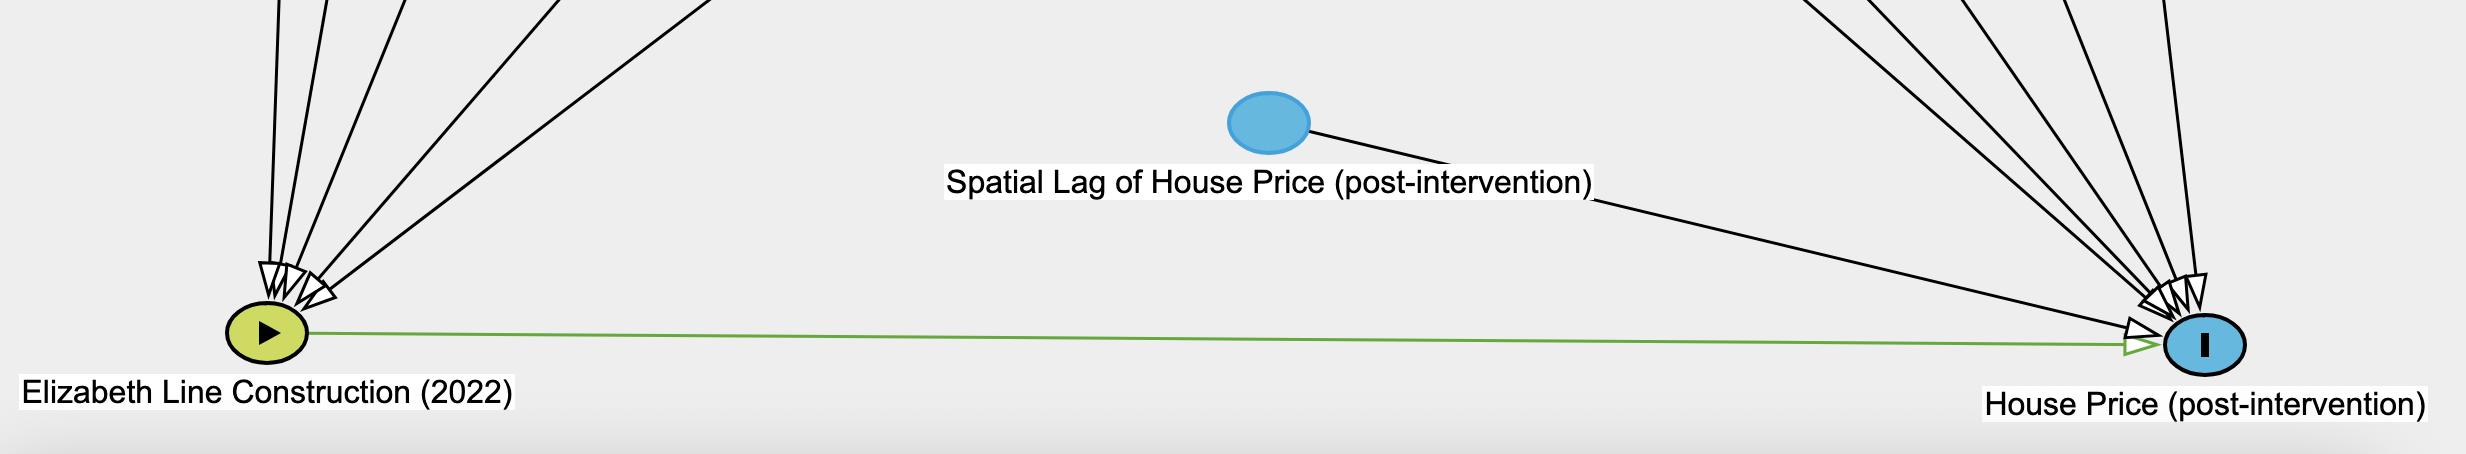

In this case, we're assuming the spatial lag of 2024 house prices is an ancestor of the outcome - it *cannot* be a confounder for 2024 house price as it is not possible for it to have affected treatment propensity (which happened *before* 2024). But if it is simply an ancestor of the outcome, controlling for it should increase the precision of our treatment effect estimate.

Unless, that is, building the Elizabeth Line increases house prices in a given area, *as well as the house prices of **that area's neighbours***. In that case, this variable will function as a **mediator** between the treatment and outcome, so controlling for the spatial lag of post-intervention house price would leave us with an estimate of only the **direct effect** of construction on house prices, rather than the **total effect**. 

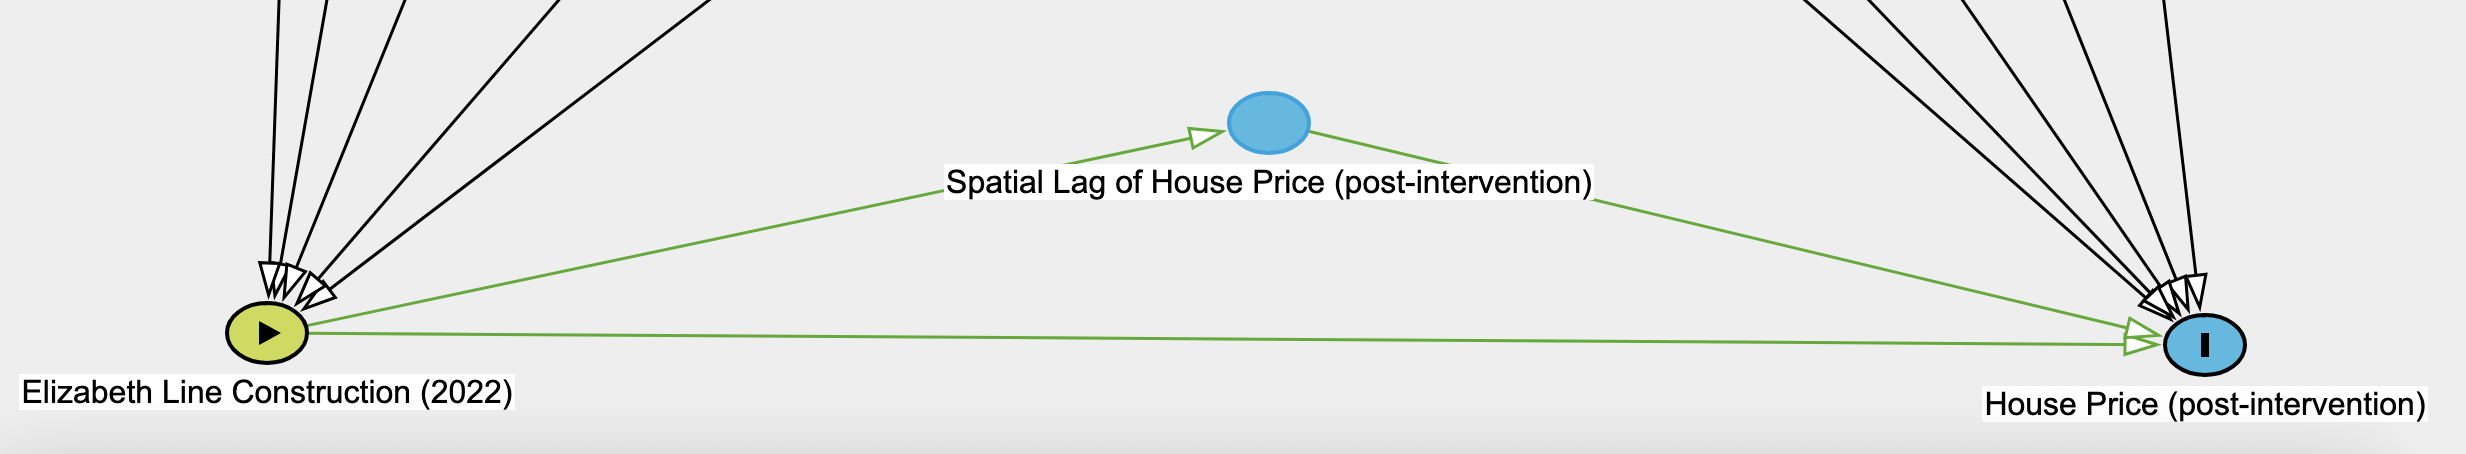

We could test for this empirically by assessing whether there are *spatial spillovers* in the treatment effect (more on that below). However, there is a third way of looking at this relationship, which is that one OA's house prices affect its neighbours *and vice-versa*: spatial spillovers of this kind, by nature, are not uni-directional; if my neighbours' house prices are affecting mine, then I will also be affecting theirs.

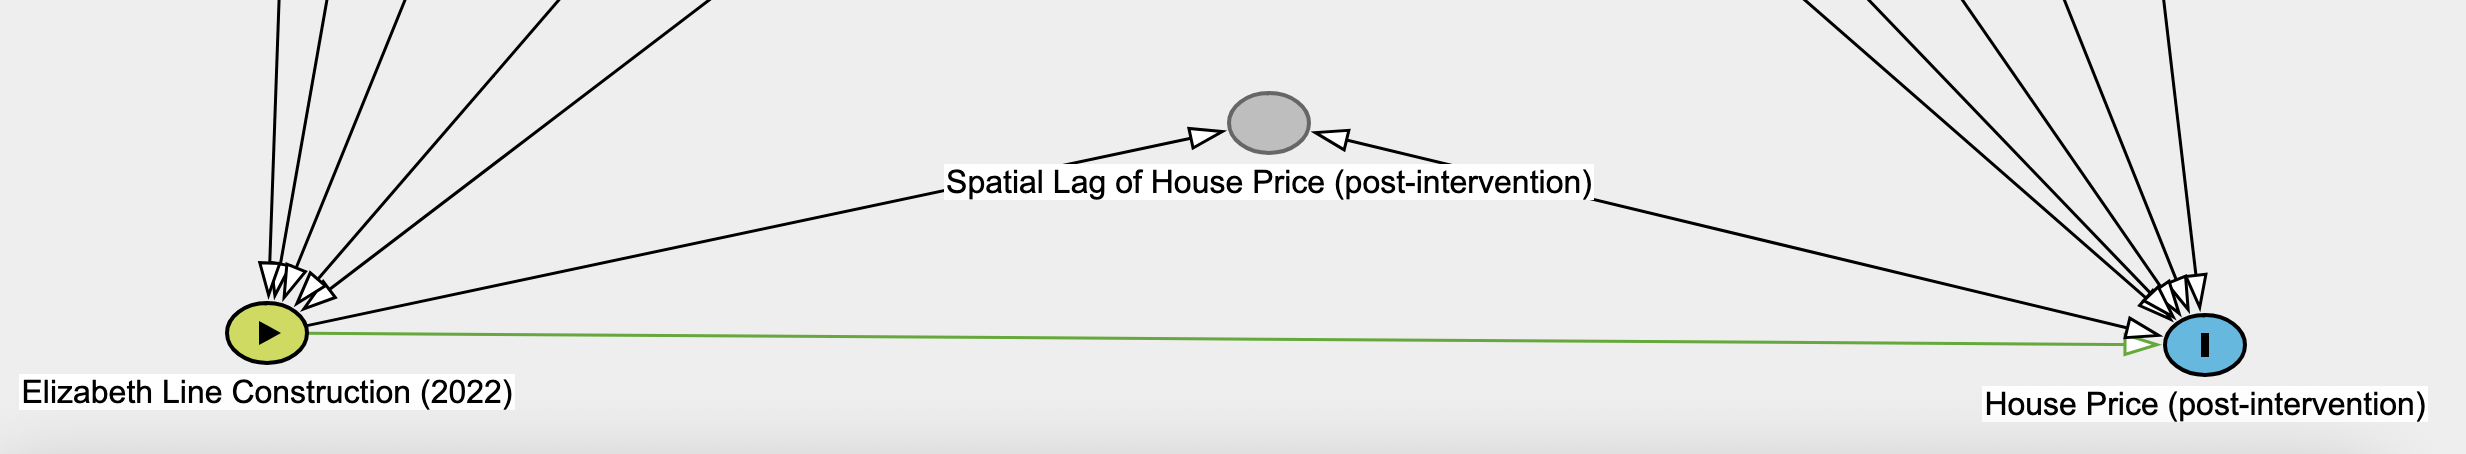

In this case we have a more serious problem: the spatial lag has become a **collider**, and in fact controlling for it will potentially bias our estimates of the treatment effect. So while it is possible that including the spatial lag of $Y$ might improve our estimates of the treatment effect, in practice it seems unlikely that this kind of setup would occur: it would have to be a case where the spatial spillovers are not reciprocal (i.e., neighbouring values of the outcome influence your outcome, but the effect is not returned).

We could possibly try to empirically assess this (crudely) by looking at the slope of the relationship between $Y$ and $WY$ with each as the dependent variable in turn to see which is larger (i.e., which predict the other with a larger magnitude).

In [ ]:
# Create weights
w = weights.DistanceBand.from_dataframe(oa_m4, 800)

# Remove islands using position indices
if len(w.islands) > 0:
    # Get indices to keep (everything except islands)
    keep_idx = [i for i in range(len(oa_m4)) if i not in w.islands]
    oa_m4_clean = oa_m4.iloc[keep_idx].reset_index(drop=True)
    w = weights.DistanceBand.from_dataframe(oa_m4_clean, 800)
else:
    oa_m4_clean = oa_m4

w.transform = 'r'

# Calculate spatial lag
Y = oa_m4_clean['log_price2024'].values
lag_Y = weights.spatial_lag.lag_spatial(w, Y)

# Calculate slopes
slope_Y_on_lag = linregress(lag_Y, Y)[0]  # Y ~ lag
slope_lag_on_Y = linregress(Y, lag_Y)[0]  # lag ~ Y

print(f"Slope (Y ~ lag): {slope_Y_on_lag:.4f}")
print(f"Slope (lag ~ Y): {slope_lag_on_Y:.4f}")

In this case it appears that $Y$ predicts a larger increase in $WY$ than the other way around, which, if not confirming the arrow from outcome to spatial lag in the DAG above, certainly doesn't disprove it. In our case - and, it would seem, most cases - it is perhaps safest to remove the spatial lag of Y from consideration in causal analysis.

However, the SUTVA is still an important consideration. In our case, it is very realistic to assume that the benefits of a new public transport system might extend beyond the neighbourhoods that are directly treated (i.e., spatial spillovers in treatment effect), which we could model with a **spatial lag of X (SLX)** model:

__SLX__:
$Y_{POST_{A}} = T_{A}\sigma + WT_{A}\zeta + X_{A}\beta + WX_{A}\gamma + \epsilon$

Now, let's make an atempt at modeling the X variable spillovers in a new DAG. First, we'll eliminate from consideration the spatial lags of the variables that measure distance: `Dist_Transit2019` and `Dist_0KM2019`. The spatial lags of these variables are simply indirect proxies for the same distance measure, so contorlling for them will introduce a high level of multicollinearity that isn't necessary.

The relationships get complicated quickly, so let's take them one at a time. If we assume the spatial lag of confounders `log_price2019`, `DEPRHH`, and `PROFSCI` have the same relationships with other covariates as their original variables (and a reciprocal causal relationship with their original variable), they each would look something like this and become confounders themselves:

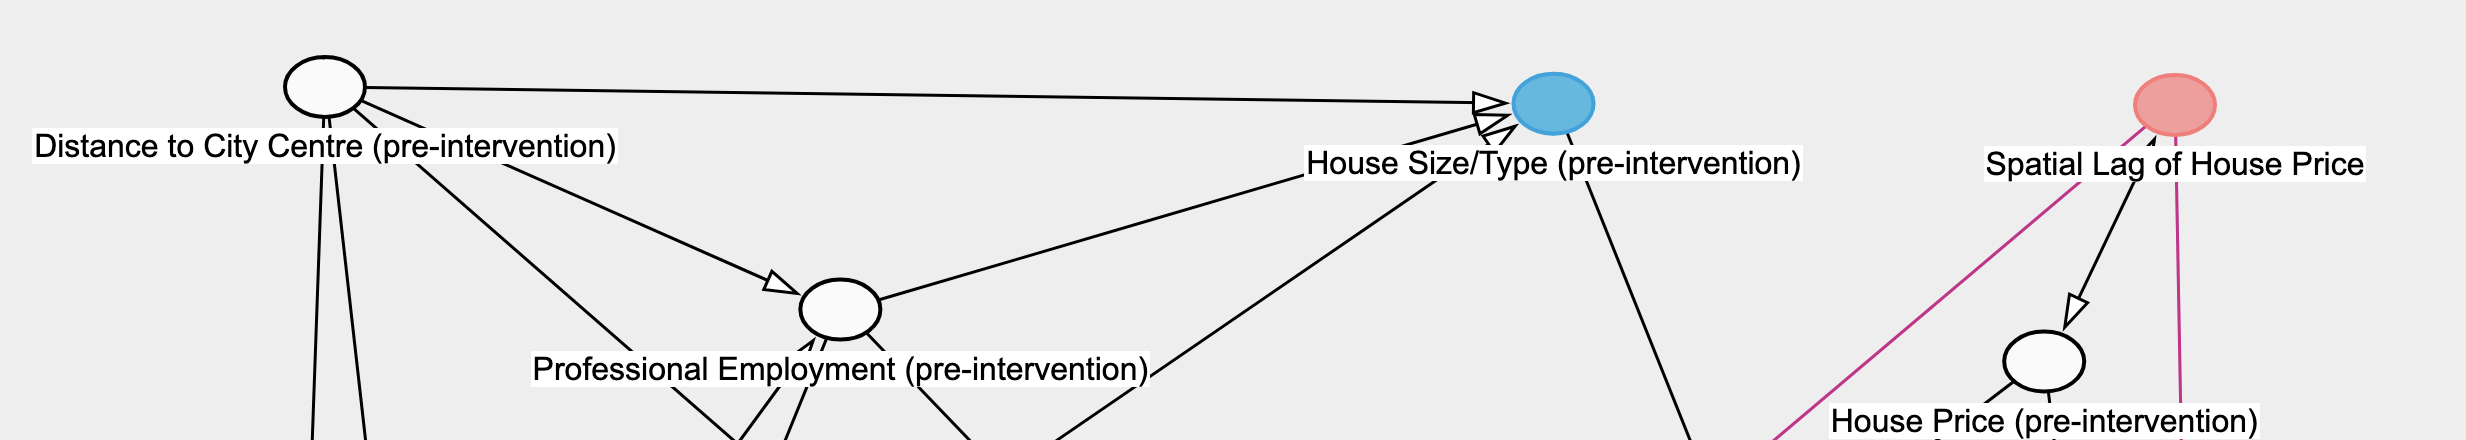

The spatial lag of `fl_area2019` remains an ancestor of the outcome:

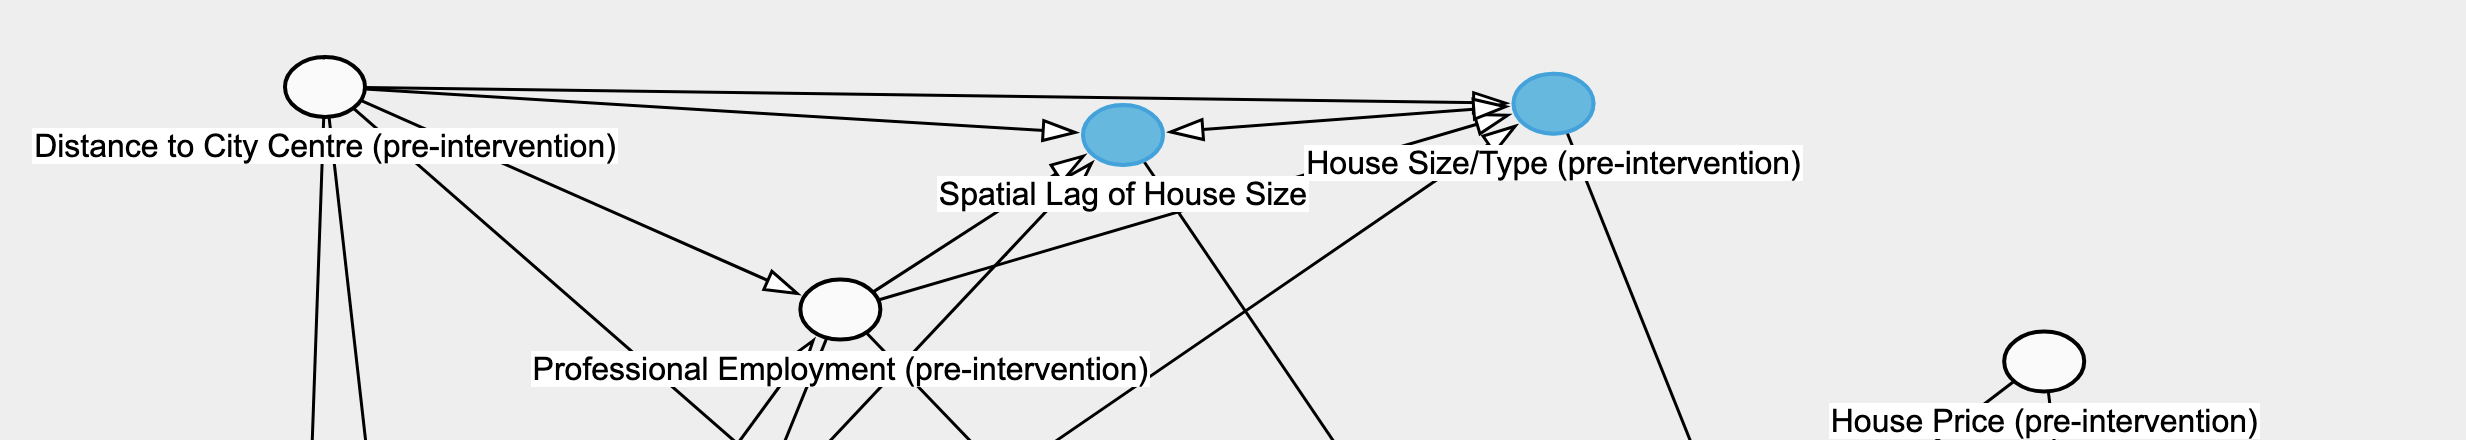

Which just leaves the spatial lag of treatment, a direct indicator of spatial spillovers in treatment effect. However, we likely do not want to *control for* these spillovers as a separate variable - we want to see the **total treatment effect** *takign into account* spillovers. To do that we will calculate the spatial lag of treatment and *add* those values to the indicator to create a continuous value (i.e., $TWT_{A} = T_{A} + WT_{A}$).

In [ ]:
slx_names = ['treat','log_price2019','fl_area2019','DEPRHH','PROFSCI','Dist_0KM2019','Dist_Transit2019']

wx = oa_m4[slx_names].apply(
    lambda y: weights.spatial_lag.lag_spatial(w, y)
# Rename the spatial lag, adding w_ to the original name
).rename(
    columns=lambda c: 'w_'+c)
# Compute the spatial lag of each of those variables
# Merge original variables with the spatial lags in `wx`
slx = oa_m4.join(wx)

In [ ]:
slx['TWT'] = slx['treat'] + slx['w_treat']

In [ ]:
slx_names2 = ['TWT','log_price2019','fl_area2019','DEPRHH','PROFSCI','Dist_0KM2019','Dist_Transit2019','w_log_price2019','w_fl_area2019','w_DEPRHH','w_PROFSCI']
ate_slx = spreg.OLS(slx[['log_price2024']].values, slx[slx_names2].values,
                name_y='log_price2024', name_x=slx_names2, robust='white', w=w, spat_diag=True, moran=True)
print(ate_slx.summary)

Overall, there are a couple of really interesting things going on in these results. First and most importantly, the combined treatment indicator `TWT` is significant, indicating a positive causal effect of proximity to the Elizabeth Line (within 800m or having neighbours within 800m) on median sales price to the tune of a £99,127 increase on average. The coefficient on this combined indicator is also somewhat smaller than the original `treat` variable, which could indicate that this combined treatment effect which accounts for spatial spillovers is more preciely estimating the true (total) treatment effect. The model R2 has also improved significantly and several of the other variables are significant, all in the expected direction of effect: median OA house price is higher in OAs that:
- are proximate to the Elizabeth Line;
- started with higher median prices;
- have *nearby* OAs with pre-intervention median prices;
- have higher median house sizes;
- have a lower % of deprived households;
- have *nearby* OAs with lower % of deprived households;
- are closer to the city centre; and
- are further from existing transit stations.

In [ ]:
bins = [200000, 500000, 1000000, 5000000] #create a user-defined classification scheme so that we can compare the two maps on the same scale

sar_treat = sar[(sar['treat']==1)] #subset by post-intervention treated

f, ax = plt.subplots(1, figsize=(15, 10))
sar_treat.to_crs('EPSG:3857').plot(ax=ax, column='price2024', legend=True, scheme='UserDefined', 
    classification_kwds={'bins': bins}, edgecolor='none', alpha=.68, aspect=1)
ax.set_axis_off() #Remove axes from plot 
ax.set_title('Treated Output Areas (800m)') #Plot title text
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

In [ ]:
sar_cont = sar[(sar['treat']==0)] #subset by post-intervention treated

f, ax = plt.subplots(1, figsize=(15, 10))
sar_cont.to_crs('EPSG:3857').plot(ax=ax, column='price2024', legend=True, scheme='UserDefined', 
    classification_kwds={'bins': bins}, edgecolor='none', alpha=.68, aspect=1)
ax.set_axis_off() #Remove axes from plot 
ax.set_title('Control Output Areas (1600m)') #Plot title text
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

## Self-Test Exercise
1. Take the individual-level difference-in-differences model and add the confounders and spatial specifications. How do the results compare to the aggregated potential outcomes results? Why do you think that is?
2. Play around with distance values for $W$ - what effects does increasing or decreasing the distance have on model outputs? What is the scientific rationale for choosing a specific distance value?
3. Include the borough-level fixed effects in the final Output Area-level potential outcomes model; what changes? Do you think it makes sense to include these fixed effects - why or why not?